# CS 168 Week 8 Discussion --- Created by Ali Hatamizadeh 

### The goal of this seesion is to implementing ResNet from Scratch and train and test on CIFAR 10 Dataset.





###Import Dependencies 

In [1]:
import numpy as np
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import tensorflow as tf
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
import keras 
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.regularizers import l1
import os
import time
from time import time

def plot_learningCurve(history,num_epoch):
  # Plot training & validation accuracy values
  epoch_range = np.arange(1,num_epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()



Using TensorFlow backend.


### Identity block implementation

In [0]:
def identity_block_101(X, f, filters):
    """
    Implementation of the identity block as defined in Slides

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X, X_shortcut])

    X = Activation('relu')(X)


    return X

###Conv block implementation 

In [0]:
def convolutional_block_101(X, f, filters,s):
    """
    Implementation of the convolutional block as defined in Slides

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stride -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1,kernel_size=(1,1),strides=(s,s),padding='valid')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid')(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),padding='valid')(X_shortcut)
    X = BatchNormalization()(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    return X

###ResNet50 implementation 

In [0]:

def ResNet50(input_shape=(32, 32, 3), classes=10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64,(7,7),strides=(2,2))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides=(2,2))(X)

    # Stage 2
    X = convolutional_block_101(X,f=3,filters=[64,64,256],s=1)
    X = identity_block_101(X,3,[64,64,256])
    X = identity_block_101(X,3,[64,64,256])

    # Stage 3
    X = convolutional_block_101(X,f=3,filters=[128,128,512],s=2)
    X = identity_block_101(X,3,[128,128,512])
    X = identity_block_101(X,3,[128,128,512])
    X = identity_block_101(X,3,[128,128,512])

    # Stage 4
    X = convolutional_block_101(X,f=3,filters=[256,256,1024],s=2)
    X = identity_block_101(X,3,[256,256,1024])
    X = identity_block_101(X,3,[256,256,1024])
    X = identity_block_101(X,3,[256,256,1024])
    X = identity_block_101(X,3,[256,256,1024])
    X = identity_block_101(X,3,[256,256,1024])

    #Stage 5
    X = convolutional_block_101(X,f=3,filters=[512,512,2048],s=2)
    X = identity_block_101(X,3,[512,512,2048])
    X = identity_block_101(X,3,[512,512,2048])

    X = AveragePooling2D(pool_size=(2,2),padding='same')(X)

    X = Flatten()(X)
    X = Dense(classes,activation='softmax')(X)

    model = Model(inputs=X_input,outputs=X, name='ResNet50')


    return model

###Prepare CIFAR10 Dataset

In [5]:
batch_size = 512
num_classes = 10
data_augmentation = True

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


###Set up data augmentation 

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)


### Set up optimization and train the model

Epoch 1/100
98/98 [==============================] - 92s 934ms/step - loss: 2.7509 - accuracy: 0.2161 - val_loss: 2.3709 - val_accuracy: 0.1000
Epoch 2/100
98/98 [==============================] - 58s 587ms/step - loss: 1.8839 - accuracy: 0.3161 - val_loss: 2.4370 - val_accuracy: 0.1000
Epoch 3/100
98/98 [==============================] - 58s 589ms/step - loss: 1.7431 - accuracy: 0.3682 - val_loss: 2.5117 - val_accuracy: 0.1562
Epoch 4/100
98/98 [==============================] - 58s 589ms/step - loss: 1.6818 - accuracy: 0.3947 - val_loss: 2.2746 - val_accuracy: 0.2588
Epoch 5/100
98/98 [==============================] - 58s 588ms/step - loss: 1.6255 - accuracy: 0.4088 - val_loss: 2.1368 - val_accuracy: 0.3213
Epoch 6/100
98/98 [==============================] - 58s 590ms/step - loss: 1.5808 - accuracy: 0.4302 - val_loss: 1.8006 - val_accuracy: 0.3694
Epoch 7/100
98/98 [==============================] - 57s 586ms/step - loss: 1.5231 - accuracy: 0.4520 - val_loss: 1.5877 - val_accuracy:

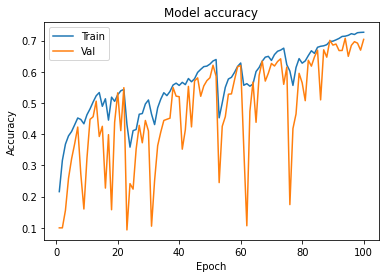

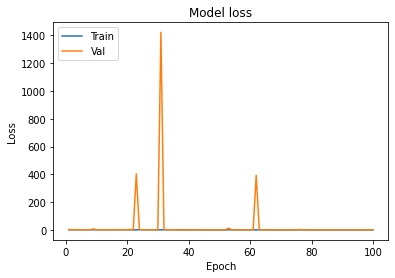

Saved trained model at /content/dog-cat-full-dataset/data/resnet/resnet51 


In [7]:
save_dir='/content/dog-cat-full-dataset/data/resnet'
epochs = 100
model = ResNet50(input_shape=(32, 32, 3), classes=10)
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])


history =model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test))


plot_learningCurve(history,epochs)

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)


model_name='resnet51'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


###Test the trained model

In [8]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 10s 1ms/step
Test loss: 0.8625605624198913
Test accuracy: 0.7038999795913696
